In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class Policy(nn.Module):
    def __init__(self, env=None):
        super().__init__()
        self.input_dim = env.observation_space.n
        self.output_dim = env.action_space.n
        
        self.l1 = nn.Linear(self.input_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, self.output_dim)

    def forward(self, x):
        x = F.one_hot(x.to(int), self.input_dim).to(torch.float32)
        a = F.relu(self.l1(x))
        a = F.relu(self.l2(a))
        a = self.l3(a)
        a = Categorical(logits=a)
        return a

In [3]:
# env = gym.make("FrozenLake-v1", is_slippery=False)
# env = gym.make("Taxi-v3")
env = gym.make("CliffWalking-v0")

policy = Policy(env)
optimizer = torch.optim.Adam(policy.parameters())

gamma = 0.99
batch_size = 16
loss = 0.0

In [4]:
rews = []
for episode in tqdm(range(100)):
    m_obs = []
    m_act = []
    m_rew = []
    
    obs, _ = env.reset()
    done = False
    
    while not done:
        p = policy(torch.tensor(obs))
        action = p.sample()
        m_obs.append(obs)
    
        obs, reward, terminated, truncated, _ = env.step(action.detach().item())
        done = terminated or truncated
    
        m_act.append(action.item())
        m_rew.append(reward)
    
    # Policy update    
    m_obs = torch.tensor(m_obs).unsqueeze(1)
    m_act = torch.tensor(m_act)
    
    G = 0
    disc_rew = []
    for reward in reversed(m_rew):
        G = reward + gamma * G
        disc_rew.insert(0, G)
    
    rews.append(G)
    
    for obs_, act_, rew_ in zip(m_obs, m_act, disc_rew):
        log_prob = policy(obs_).log_prob(act_)
        loss -= log_prob * rew_
    
    if episode % batch_size == 0 and episode != 0:    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = 0.0
        
        print(sum(rews) / batch_size)
        rews = []

 17%|█▋        | 17/100 [01:41<14:43, 10.64s/it]

-1170.18215328294


 33%|███▎      | 33/100 [04:57<30:31, 27.33s/it]

-861.1470778078497


 49%|████▉     | 49/100 [07:01<14:19, 16.85s/it]

-657.1967618042889


 65%|██████▌   | 65/100 [09:35<14:07, 24.22s/it]

-636.5534843312034


 81%|████████  | 81/100 [13:59<11:23, 35.99s/it]

-446.8408429941061


 91%|█████████ | 91/100 [16:55<02:32, 16.90s/it]

tensor([[0.0114, 0.9434, 0.0315, 0.0136]])
tensor(1)


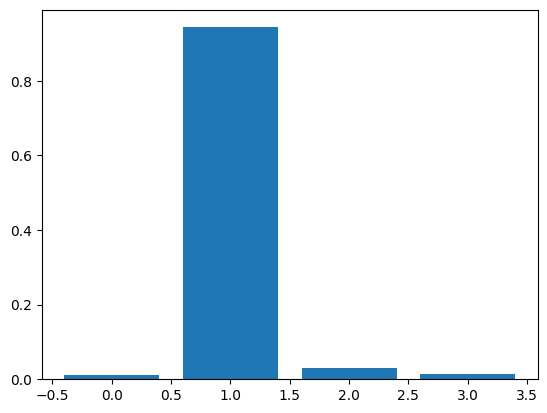

In [ ]:
with torch.no_grad():
    a = policy(torch.Tensor([4]))
    print(a.probs)
    print(a.probs.argmax())

plt.bar(x=range(4), height=a.probs[0].detach().numpy())
plt.show()